In [1]:
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.utils import save_image
import torchvision.models as tvmodels
from torchvision import datasets, transforms

import segmentation_models_pytorch as smp

import numpy as np

import matplotlib.pyplot as plt

sys.path.insert(0, "../src")
import exlib
from exlib.explainers import *
from exlib.modules import *
from exlib.datasets.abdomen_organs import *

In [2]:
DATA_DIR = "/home/antonxue/foo/data/abdomen_exlib/"
train_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="train")
test_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="test")

In [3]:
state_dict = torch.load("/home/antonxue/foo/real_drs/saved_models/weiqiu_model2.pt")

In [4]:
model = AbodmenSegmentationModel(in_channels=3, out_channels=3)
# model.unet = smp.Unet(
#         encoder_name = "resnet50",
#         encoder_weights = "imagenet",
#         in_channels = 3,
#         classes = 3,
#         activation = "softmax2d"
#     )
model.unet.load_state_dict(state_dict["model_state_dict"])
model.unet.eval()
model.eval();

In [5]:
x, olabel, glabel = test_dataset[2]
y = model(x[None,...])

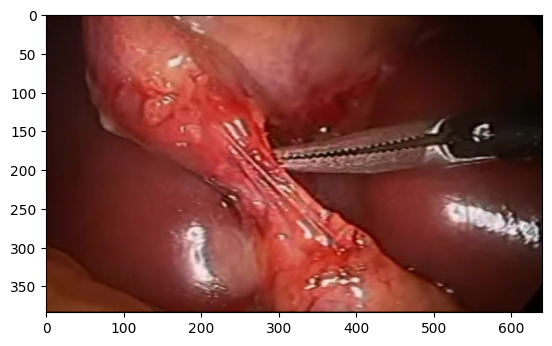

In [6]:
plt.imshow(x.numpy().transpose(1,2,0))

In [7]:
(y.argmax(dim=1) == 0).sum(), (y.argmax(dim=1) == 1).sum(), (y.argmax(dim=1) == 2).sum()

(tensor(245760), tensor(0), tensor(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

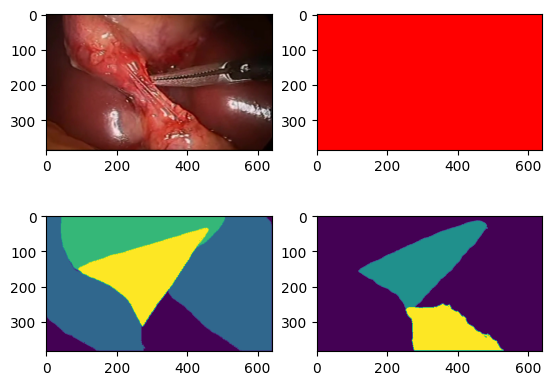

In [8]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x.numpy().transpose(1,2,0))
ax[0,1].imshow(40 * y[0].detach().numpy().transpose(1,2,0))
ax[1,0].imshow(30 * olabel.numpy().transpose(1,2,0))
ax[1,1].imshow(40 * glabel.numpy().transpose(1,2,0))

In [9]:
########################################
########################################
########################################

In [10]:
cls_model = AbdomenClassificationModel(3, 6)

In [11]:
X = torch.stack([x,x])
y = cls_model(X)
y

tensor([[ 0.7161, -0.2091,  0.2278, -0.5150,  0.0696,  0.2476],
        [ 0.7161, -0.2091,  0.2278, -0.5150,  0.0696,  0.2476]],
       grad_fn=<AddmmBackward0>)

In [12]:
# Try an explainer

In [13]:
# explainer = IntGradImageSeg(model)
intg_class = IntGradImageClass(cls_model)
intg_seg = IntGradImageSeg(model)                       

new_lime = LimeImageClass(cls_model)
old_lime = TorchImageLime(cls_model)

In [14]:
intg_class_exp = intg_class(X)

preparation y is tensor([[ 0.7161, -0.2091,  0.2278, -0.5150,  0.0696,  0.2476],
        [ 0.7161, -0.2091,  0.2278, -0.5150,  0.0696,  0.2476]],
       grad_fn=<AddmmBackward0>)
preparation label is tensor([0, 0])


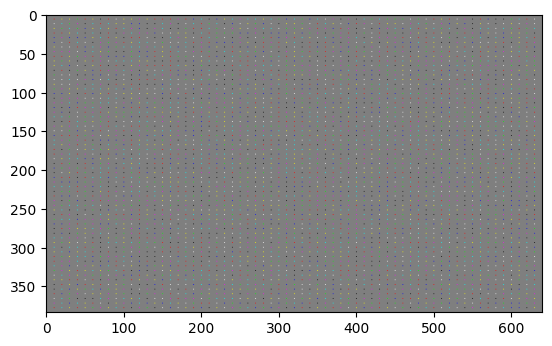

In [15]:
plt.imshow(intg_class_exp.attributions[1].sigmoid_().numpy().transpose(1,2,0), cmap="gray")

In [16]:
intg_seg_exp = intg_seg(X, label=torch.tensor([0,2]))

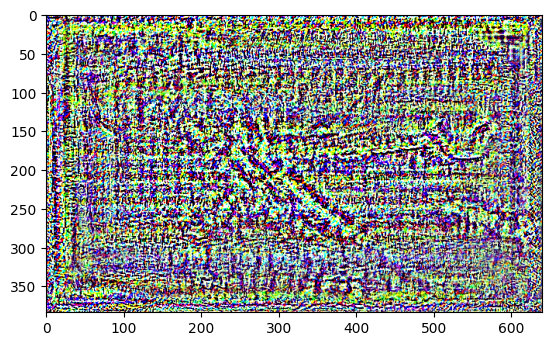

In [19]:
plt.imshow(intg_seg_exp.attributions[1].sigmoid_().numpy().transpose(1,2,0), cmap="gray")

In [17]:

new_attrs = new_lime(X, label=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
new_attrsB = new_lime(X, label=[0,2])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
old_attrs = old_lime(X, label=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
old_attrs.explainer_output[0].top_labels

[4, 7, 6, 2, 8]

In [21]:
new_attrs.top_labels

AttributeError: 'FeatureAttrOutput' object has no attribute 'top_labels'

In [23]:
new_attrs.explainer_output[0].top_labels

[4, 7, 6, 2, 8, 9, 3, 0, 1, 5]

In [24]:
old_attrs.explainer_output[0].top_labels

[4, 7, 6, 2, 8]

In [ ]:
new_attrs.attributions.shape

In [ ]:
old_attrs.attributions.shape

In [ ]:
new_attrs.attributions[0].shape

In [ ]:
plt.figure()
fig, ax = plt.subplots(1,3)
ax[0].imshow(new_attrs.attributions[0].unsqueeze(0).numpy().transpose(1,2,0))
ax[1].imshow(new_attrs.attributions[1].unsqueeze(0).numpy().transpose(1,2,0))
ax[2].imshow(new_attrs.attributions[2].unsqueeze(0).numpy().transpose(1,2,0))

In [ ]:
plt.figure()
fig, ax = plt.subplots(1,3)
ax[0].imshow(old_attrs.attributions[0].unsqueeze(0).numpy().transpose(1,2,0))
ax[1].imshow(old_attrs.attributions[1].unsqueeze(0).numpy().transpose(1,2,0))
ax[2].imshow(old_attrs.attributions[2].unsqueeze(0).numpy().transpose(1,2,0))

In [ ]:
old_attrs.explainer_output[0].local_exp.keys()

In [ ]:
# Use their models. 

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
# Load the model
smp_model = smp.Unet(
    encoder_name="resnet34",    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet", # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,              # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                  # model output channels (number of classes in your dataset)
    activation='softmax2d'
)

state_dict_path = "/home/antonxue/foo/real_drs/saved_models/weiqiu_model.pt"
state_dict = torch.load(state_dict_path, map_location="cpu")
smp_model.load_state_dict(state_dict["model"])
smp_model.eval()
;

In [ ]:
x, olabel, glabel = test_dataset[0]

x_go = x.clone()
x_go[2:,:,] = 1.0
x_go = x_go *  (glabel == 1)

x_nogo = x.clone()
x_nogo[0,:,:] = 1.0
x_nogo = x_nogo * (glabel == 2)

x_gonogo = (1 - (glabel == 1).int() - (glabel == 2).int()) * x + x_go + x_nogo

In [ ]:
smp_explainer = IntGradImageSeg(smp_model)

In [ ]:
X = torch.stack([x,x,x])
smp_intg = smp_explainer(X, labels=[0,1,2], num_steps=8, progress_bar=True)

In [ ]:
alphas = smp_intg.attributions.cpu().detach()
q = alphas.view(-1).quantile(0.95)
pas = (alphas.abs() > q) * 1.0

In [ ]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x.numpy().transpose(1,2,0))
ax[0,1].imshow(x_gonogo.numpy().transpose(1,2,0))

# ax[0,1].imshow(pas[0].numpy().transpose(1,2,0))
ax[1,0].imshow(pas[1].numpy().transpose(1,2,0))
ax[1,1].imshow(pas[2].numpy().transpose(1,2,0))

In [ ]:
xfile = test_dataset.image_filenames[0]
dump_dir = "/home/antonxue/foo/test/dump/"
save_image(x, dump_dir + xfile)
save_image(x_gonogo, dump_dir + xfile + ".gonogo.png")
save_image(pas[0], dump_dir + xfile + ".intgrad.png")

In [19]:
torch.tensor(x)

tensor([1, 9, 2, 8, 3, 7, 4, 6, 5])

In [20]:
x[4] = x[6]

In [21]:
x

array([1, 9, 2, 8, 4, 7, 4, 6, 5])

In [18]:
x = np.array([1,9,2,8,3,7,4,6,5])

In [21]:
x[:10000]

array([1, 9, 2, 8, 3, 7, 4, 6, 5])